# Empirical Value at Risk (VaR) and Conditional Value at Risk (CVaR)

- Choose of of the Pnl return series from [Profit and Loss Historical Simulation](pnl_historical_simulation.ipynb),
- display distribution,
- highlight the VaR limit & value,
- highlight the CVaR area & value,
- interpret

In [53]:

import math
import random as random

import pandas as pd

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

# fixes the seed for reproducibility
rng = default_rng(99)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy
from scipy.optimize import fsolve

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'



# reload backed up calcs
# pd.options.mode.chained_assignment = None
btcusd_1min = pd.read_csv('btcusd_1min_with_all.csv')

# stats inference window
N_lookback = 180

## Model selection

As we can see from the [Profit and Loss Historical Simulation](pnl_historical_simulation.ipynb) results, the constant fee resulting in the most conservative non-negative cummulative PnL is the 10bips. 

That fee level is dependent on the data set and will change as the data changes. Constant fees were used to highlight how such a fee structure would only make sense if absolute profit is the goal versus fair-pricing / risk-balancing.

The BSM model and it's Normal MC counterpart also result in the most conservative non-negative cummulative PnL of the dynamic fee models. It overcharges but sits between the 10bips and the 11bips.

The Laplace is "slightly" negative and sits between the 9bips and the 10bips. It is also the closest to the 0 Pnl fair-pricing, which could mean that more investigation is warranted.

The Student's t is unstanble with df ~=2 (a degree of freedom, df = 2, means an infinite variance) so it can be discarded.

So final choice for ease of use and analytical formula availability (i.e. no MC simulation required) falls on the **BSM**.

## Value at Risk (VaR)


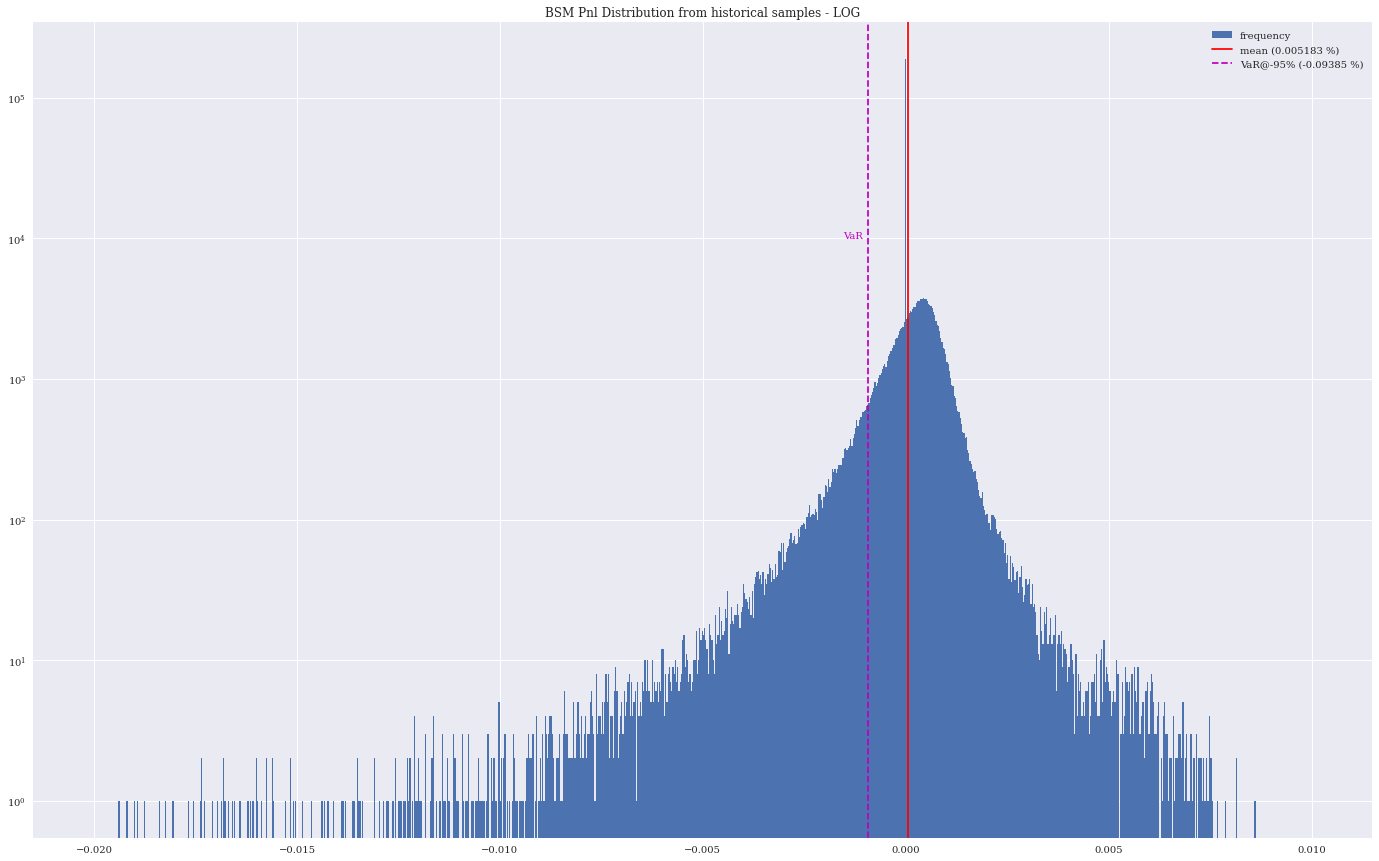


### PnL return mean
|variable|value|
|:-:|-:|
|ret_bsm_pnl mean|0.0051827 %|

### PnL return @-95%
|variable|value|
|:-:|-:|
|ret_bsm_pnl @-95%|-0.093846 %|



In [61]:
# distribution of the pnl "return" VaR @ confidence level = 95%

# alias
ret_bsm_pnl = btcusd_1min['ret_bsm_pnl'][N_lookback + 2:-2]

# var @ 95
CL = 95
ONE_MINUS_CL = 100 - CL
var_cl = np.percentile(ret_bsm_pnl, ONE_MINUS_CL)


plt.figure(figsize=(24, 15))
plt.hist(ret_bsm_pnl, bins=1000, label='frequency', log=True, range=[-0.02,0.01]);

plt.axvline(ret_bsm_pnl.mean(), color='r', label=f"mean ({float('%.4g' % (100*ret_bsm_pnl.mean()))} %)")
plt.axvline(var_cl, color='m', label=f"VaR@-{CL}% ({float('%.4g' % (100*var_cl))} %)", linestyle='--')

plt.text(var_cl-0.0006, 10000, "VaR", color='m')

plt.title(f'BSM Pnl Distribution from historical samples - LOG')
plt.legend(loc='best');
plt.show()



header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|ret_bsm_pnl mean|{100*ret_bsm_pnl.mean():,.5g} %|\n"

table2 = ""
table2 += f"|ret_bsm_pnl @-{CL}%|{100*var_cl:,.5g} %|\n"

md(f"""
### PnL return mean
{header}
{table}
### PnL return @-95%
{header}
{table2}
""")


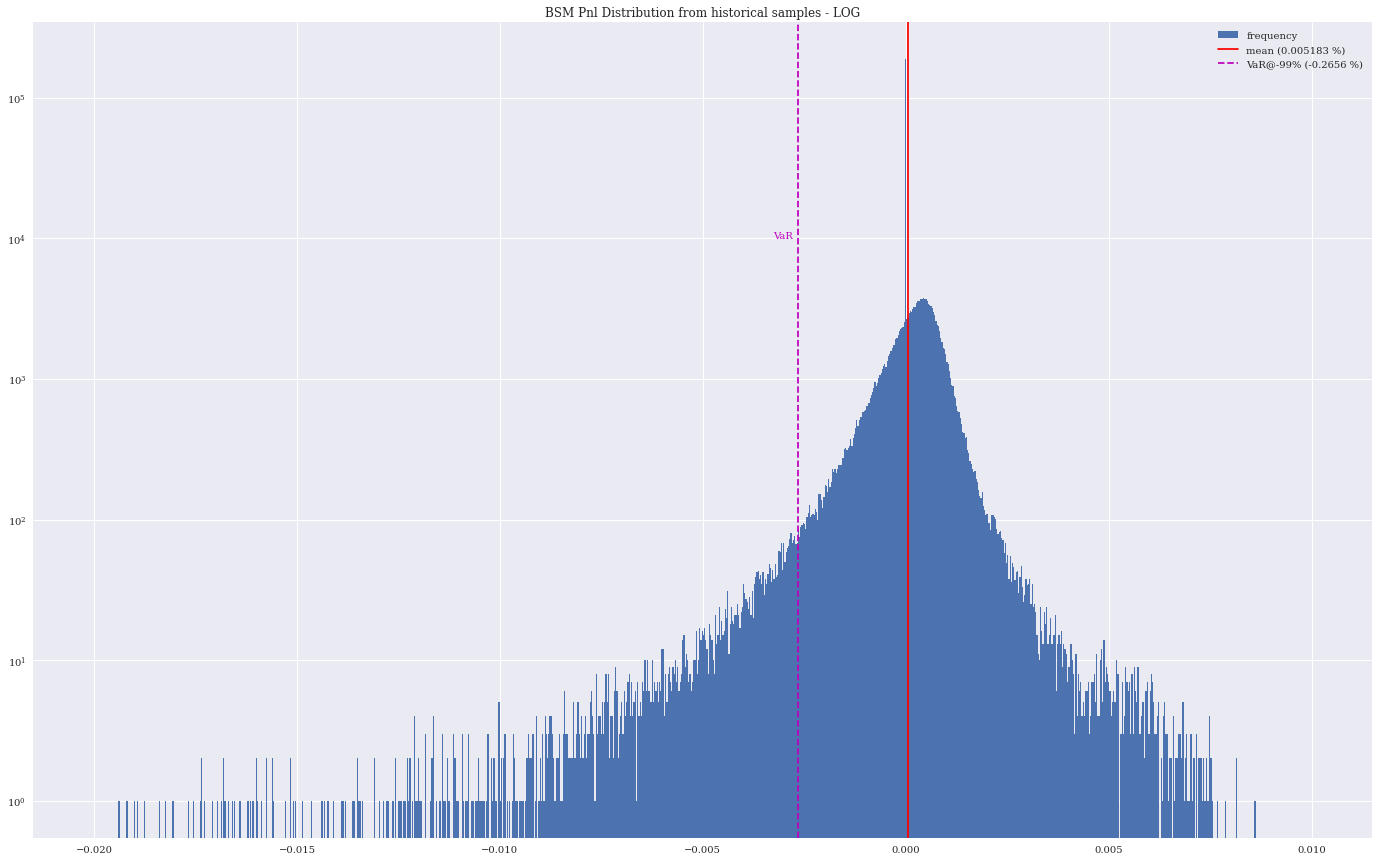


### PnL return mean
|variable|value|
|:-:|-:|
|ret_bsm_pnl mean|0.0051827 %|

### PnL return @-99%
|variable|value|
|:-:|-:|
|ret_bsm_pnl @-99%|-0.26564 %|



In [60]:
# distribution of the pnl "return" VaR @ confidence level = 99%

# alias
ret_bsm_pnl = btcusd_1min['ret_bsm_pnl'][N_lookback + 2:-2]

# var @ 99
CL = 99
ONE_MINUS_CL = 100 - CL
var_cl = np.percentile(ret_bsm_pnl, ONE_MINUS_CL)


plt.figure(figsize=(24, 15))
plt.hist(ret_bsm_pnl, bins=1000, label='frequency', log=True, range=[-0.02,0.01]);

plt.axvline(ret_bsm_pnl.mean(), color='r', label=f"mean ({float('%.4g' % (100*ret_bsm_pnl.mean()))} %)")
plt.axvline(var_cl, color='m', label=f"VaR@-{CL}% ({float('%.4g' % (100*var_cl))} %)", linestyle='--')

plt.text(var_cl-0.0006, 10000, "VaR", color='m')

plt.title(f'BSM Pnl Distribution from historical samples - LOG')
plt.legend(loc='best');
plt.show()



header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|ret_bsm_pnl mean|{100*ret_bsm_pnl.mean():,.5g} %|\n"

table2 = ""
table2 += f"|ret_bsm_pnl @-{CL}%|{100*var_cl:,.5g} %|\n"

md(f"""
### PnL return mean
{header}
{table}
### PnL return @-99%
{header}
{table2}
""")


### Daily time-horizon


## Conditional Value at Risk (CVaR)

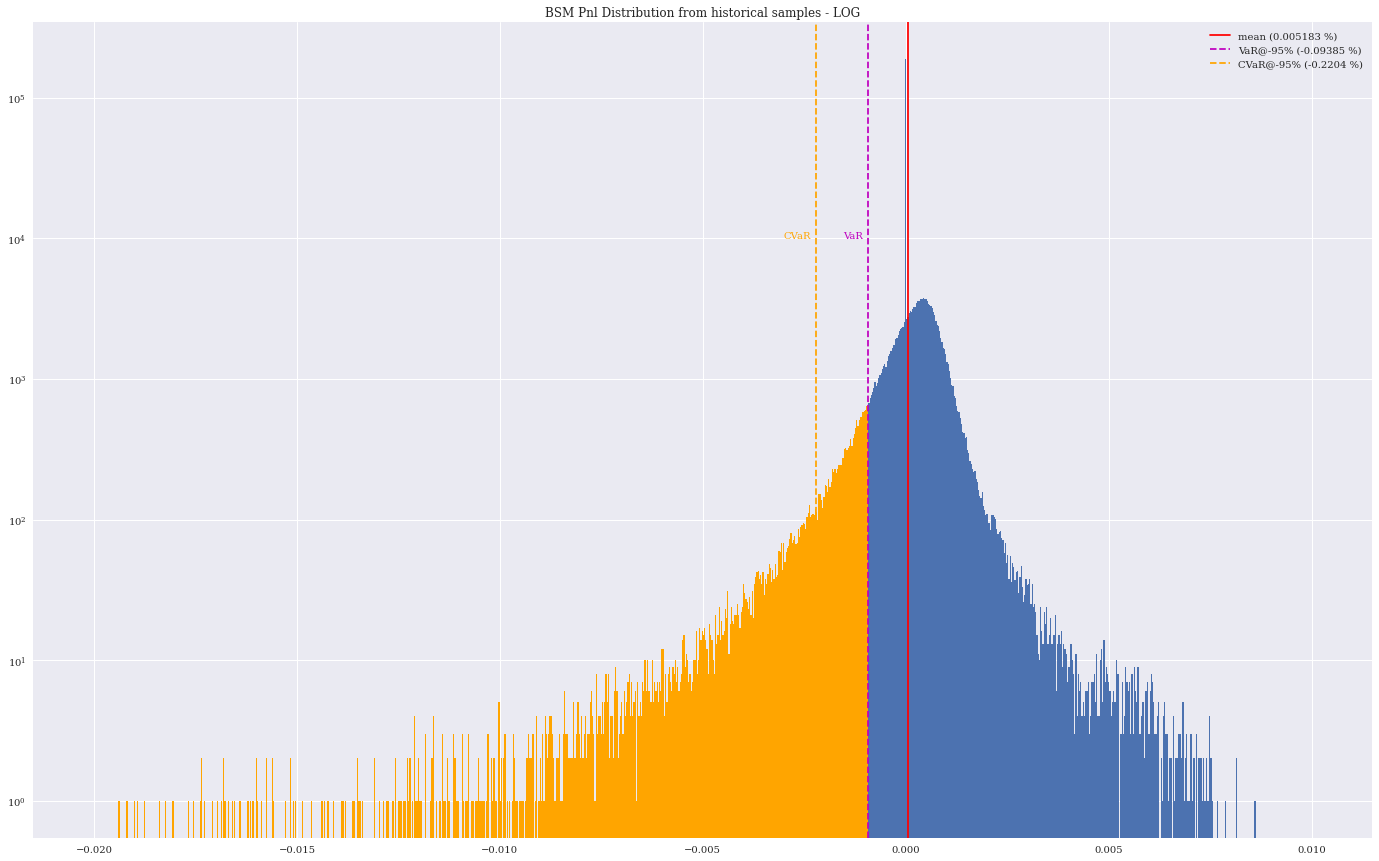


### PnL return mean
|variable|value|
|:-:|-:|
|ret_bsm_pnl mean|0.0051827 %|

### PnL return @-95%
|variable|value|
|:-:|-:|
|ret_bsm_pnl @-95%|-0.093846 %|

### PnL Expected[return] < @-95%
|variable|value|
|:-:|-:|
|ret_bsm_pnl E[r \| r < @-95%]|-0.22037 %|



In [56]:
# distribution of the pnl "return" CVaR @ confidence level = 95%

# alias
ret_bsm_pnl = btcusd_1min['ret_bsm_pnl'][N_lookback + 2:-2]
ret_bsm_pnl_mean = ret_bsm_pnl.mean()

# var @ 95
CL = 95
ONE_MINUS_CL = 100 - CL
var_cl = np.percentile(ret_bsm_pnl, ONE_MINUS_CL)
cvar_cl = ret_bsm_pnl[ret_bsm_pnl < var_cl].mean()


plt.figure(figsize=(24, 15))
n, bins, patches = plt.hist(ret_bsm_pnl, bins=1000, log=True, range=[-0.02,0.01]);
# n, bins, patches = plt.hist(ret_bsm_pnl, bins=100, range=[-0.02,0.01]);
for c, p in zip(bins, patches):
    if c < var_cl:
        plt.setp(p, 'facecolor', 'orange')

plt.axvline(ret_bsm_pnl_mean, color='r', label=f"mean ({float('%.4g' % (100*ret_bsm_pnl_mean))} %)")
plt.axvline(var_cl, color='m', label=f"VaR@-{CL}% ({float('%.4g' % (100*var_cl))} %)", linestyle='--')
plt.axvline(cvar_cl, color='orange', label=f"CVaR@-{CL}% ({float('%.4g' % (100*cvar_cl))} %)", linestyle='--')

plt.text(var_cl-0.0006, 10000, "VaR", color='m')
plt.text(cvar_cl-0.0008, 10000, "CVaR", color='orange')

plt.title(f'BSM Pnl Distribution from historical samples - LOG')
plt.legend(loc='best');
plt.show()



header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|ret_bsm_pnl mean|{100*ret_bsm_pnl_mean:,.5g} %|\n"

table2 = ""
table2 += f"|ret_bsm_pnl @-{CL}%|{100*var_cl:,.5g} %|\n"

table3 = ""
table3 += f"|ret_bsm_pnl E[r \| r < @-{CL}%]|{100*cvar_cl:,.5g} %|\n"

md(f"""
### PnL return mean
{header}
{table}
### PnL return @-95%
{header}
{table2}
### PnL Expected[return] < @-95%
{header}
{table3}
""")


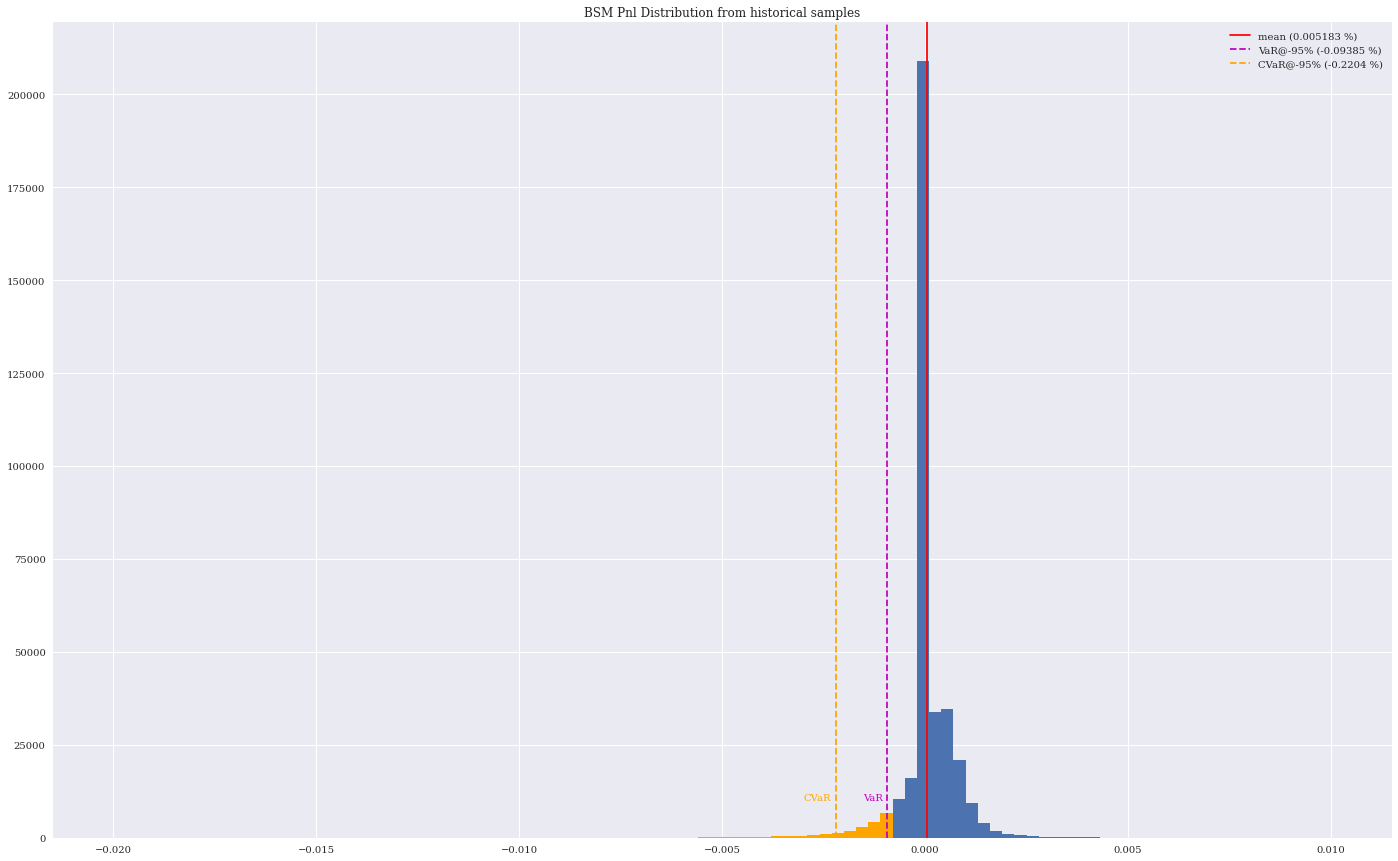


### PnL return mean
|variable|value|
|:-:|-:|
|ret_bsm_pnl mean|0.0051827 %|

### PnL return @-95%
|variable|value|
|:-:|-:|
|ret_bsm_pnl @-95%|-0.093846 %|

### PnL Expected[return] < @-95%
|variable|value|
|:-:|-:|
|ret_bsm_pnl E[r \| r < @-95%]|-0.22037 %|



In [57]:

# distribution of the pnl "return" CVaR @ confidence level = 95%

# alias
ret_bsm_pnl = btcusd_1min['ret_bsm_pnl'][N_lookback + 2:-2]
ret_bsm_pnl_mean = ret_bsm_pnl.mean()

# var @ 95
CL = 95
ONE_MINUS_CL = 100 - CL
var_cl = np.percentile(ret_bsm_pnl, ONE_MINUS_CL)
cvar_cl = ret_bsm_pnl[ret_bsm_pnl < var_cl].mean()


plt.figure(figsize=(24, 15))
# n, bins, patches = plt.hist(ret_bsm_pnl, bins=1000, log=True, range=[-0.02,0.01]);
n, bins, patches = plt.hist(ret_bsm_pnl, bins=100, range=[-0.02,0.01]);
for c, p in zip(bins, patches):
    if c < var_cl:
        plt.setp(p, 'facecolor', 'orange')

plt.axvline(ret_bsm_pnl_mean, color='r', label=f"mean ({float('%.4g' % (100*ret_bsm_pnl_mean))} %)")
plt.axvline(var_cl, color='m', label=f"VaR@-{CL}% ({float('%.4g' % (100*var_cl))} %)", linestyle='--')
plt.axvline(cvar_cl, color='orange', label=f"CVaR@-{CL}% ({float('%.4g' % (100*cvar_cl))} %)", linestyle='--')

plt.text(var_cl-0.0006, 10000, "VaR", color='m')
plt.text(cvar_cl-0.0008, 10000, "CVaR", color='orange')

plt.title(f'BSM Pnl Distribution from historical samples')
plt.legend(loc='best');
plt.show()



header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|ret_bsm_pnl mean|{100*ret_bsm_pnl_mean:,.5g} %|\n"

table2 = ""
table2 += f"|ret_bsm_pnl @-{CL}%|{100*var_cl:,.5g} %|\n"

table3 = ""
table3 += f"|ret_bsm_pnl E[r \| r < @-{CL}%]|{100*cvar_cl:,.5g} %|\n"

md(f"""
### PnL return mean
{header}
{table}
### PnL return @-95%
{header}
{table2}
### PnL Expected[return] < @-95%
{header}
{table3}
""")


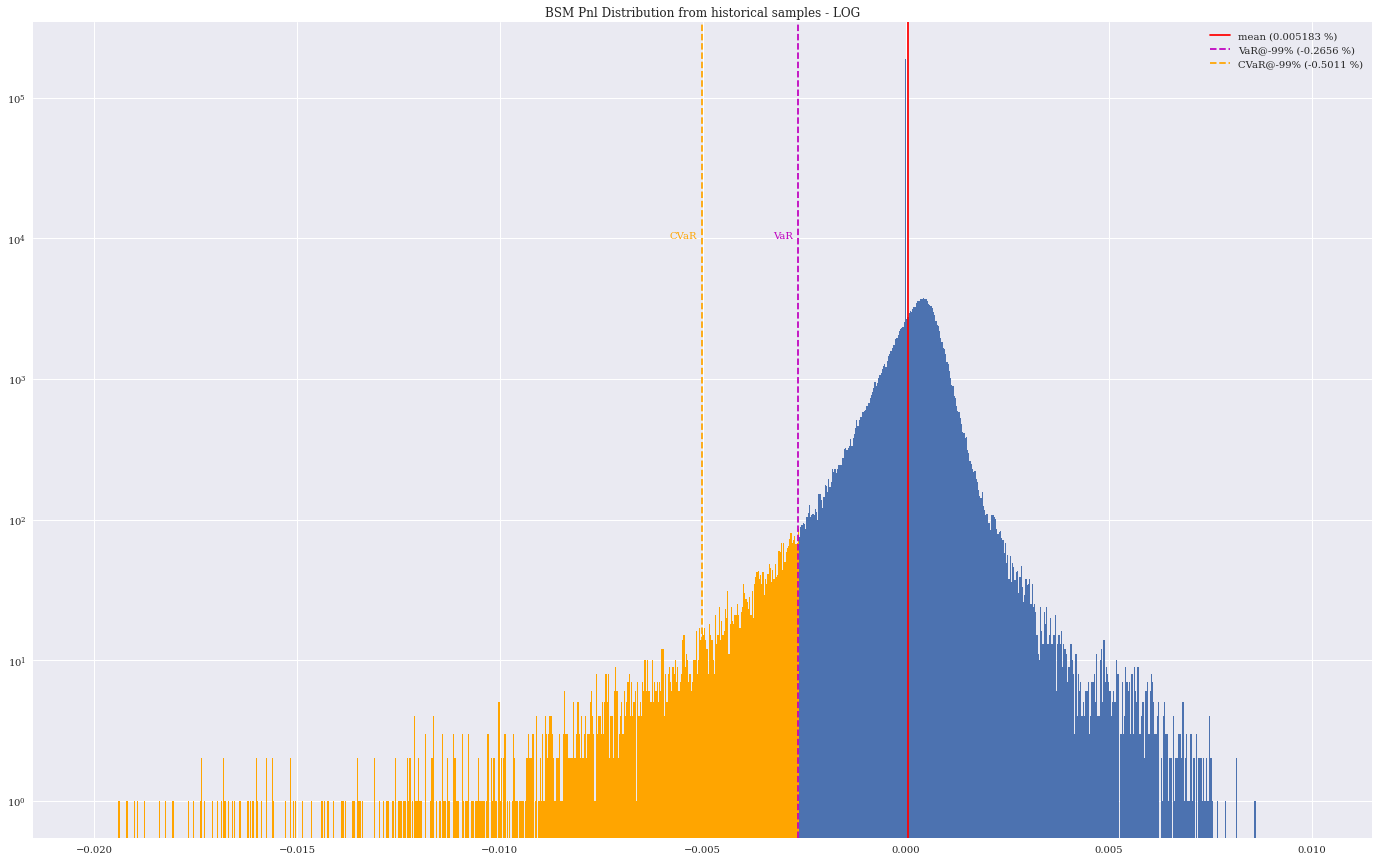


### PnL return mean
|variable|value|
|:-:|-:|
|ret_bsm_pnl mean|0.0051827 %|

### PnL return @-99%
|variable|value|
|:-:|-:|
|ret_bsm_pnl @-99%|-0.26564 %|

### PnL Expected[return] < @-99%
|variable|value|
|:-:|-:|
|ret_bsm_pnl E[r \| r < @-99%]|-0.50115 %|



In [58]:
# distribution of the pnl "return" CVaR @ confidence level = 99%

# alias
ret_bsm_pnl = btcusd_1min['ret_bsm_pnl'][N_lookback + 2:-2]
ret_bsm_pnl_mean = ret_bsm_pnl.mean()

# var @ 99
CL = 99
ONE_MINUS_CL = 100 - CL
var_cl = np.percentile(ret_bsm_pnl, ONE_MINUS_CL)
cvar_cl = ret_bsm_pnl[ret_bsm_pnl < var_cl].mean()


plt.figure(figsize=(24, 15))
n, bins, patches = plt.hist(ret_bsm_pnl, bins=1000, log=True, range=[-0.02,0.01]);
# n, bins, patches = plt.hist(ret_bsm_pnl, bins=100, range=[-0.02,0.01]);
for c, p in zip(bins, patches):
    if c < var_cl:
        plt.setp(p, 'facecolor', 'orange')

plt.axvline(ret_bsm_pnl_mean, color='r', label=f"mean ({float('%.4g' % (100*ret_bsm_pnl_mean))} %)")
plt.axvline(var_cl, color='m', label=f"VaR@-{CL}% ({float('%.4g' % (100*var_cl))} %)", linestyle='--')
plt.axvline(cvar_cl, color='orange', label=f"CVaR@-{CL}% ({float('%.4g' % (100*cvar_cl))} %)", linestyle='--')

plt.text(var_cl-0.0006, 10000, "VaR", color='m')
plt.text(cvar_cl-0.0008, 10000, "CVaR", color='orange')

plt.title(f'BSM Pnl Distribution from historical samples - LOG')
plt.legend(loc='best');
plt.show()



header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|ret_bsm_pnl mean|{100*ret_bsm_pnl_mean:,.5g} %|\n"

table2 = ""
table2 += f"|ret_bsm_pnl @-{CL}%|{100*var_cl:,.5g} %|\n"

table3 = ""
table3 += f"|ret_bsm_pnl E[r \| r < @-{CL}%]|{100*cvar_cl:,.5g} %|\n"

md(f"""
### PnL return mean
{header}
{table}
### PnL return @-99%
{header}
{table2}
### PnL Expected[return] < @-99%
{header}
{table3}
""")


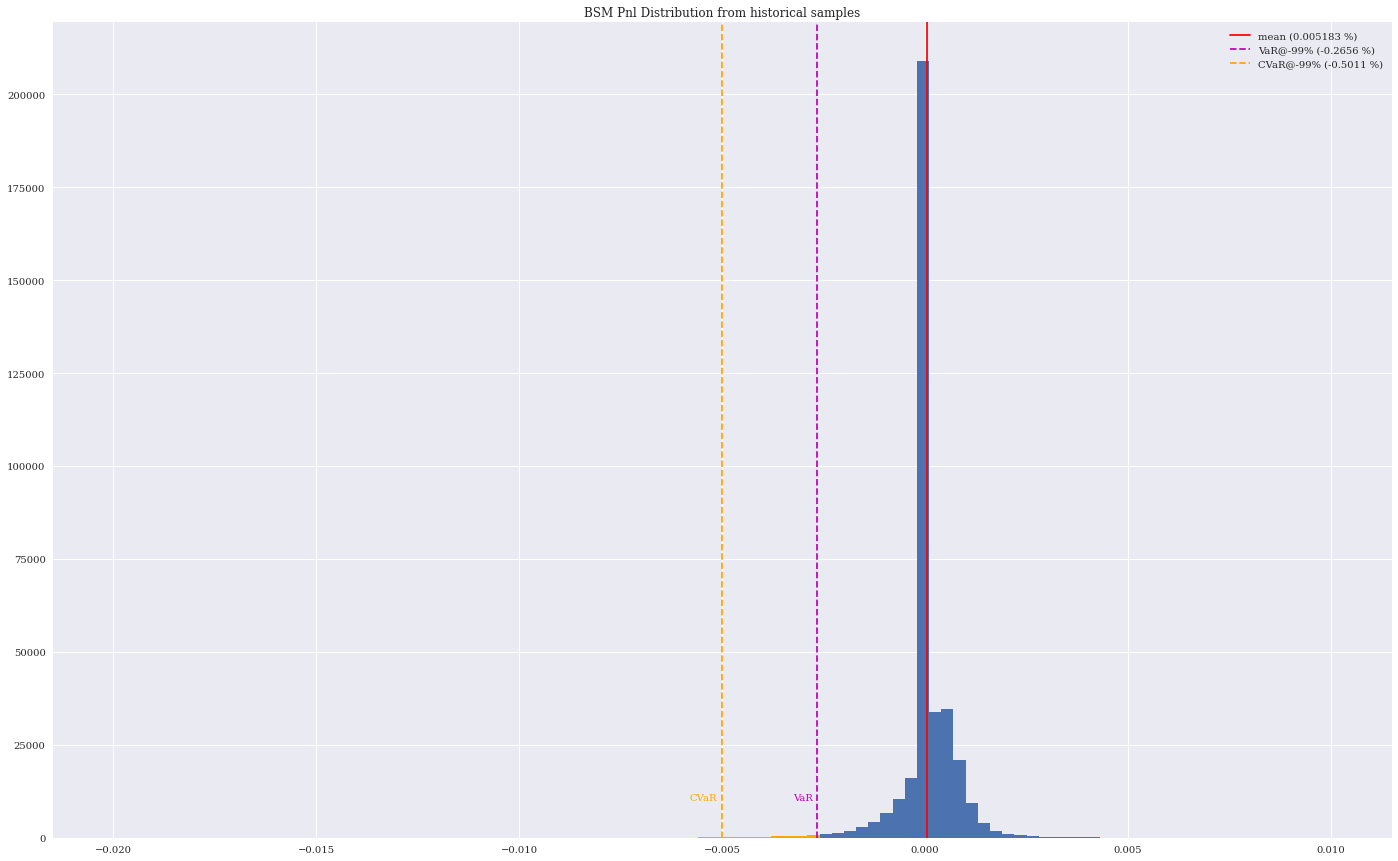


### PnL return mean
|variable|value|
|:-:|-:|
|ret_bsm_pnl mean|0.0051827 %|

### PnL return @-99%
|variable|value|
|:-:|-:|
|ret_bsm_pnl @-99%|-0.26564 %|

### PnL Expected[return] < @-99%
|variable|value|
|:-:|-:|
|ret_bsm_pnl E[r \| r < @-99%]|-0.50115 %|



In [59]:

# distribution of the pnl "return" CVaR @ confidence level = 99%

# alias
ret_bsm_pnl = btcusd_1min['ret_bsm_pnl'][N_lookback + 2:-2]
ret_bsm_pnl_mean = ret_bsm_pnl.mean()

# var @ 99
CL = 99
ONE_MINUS_CL = 100 - CL
var_cl = np.percentile(ret_bsm_pnl, ONE_MINUS_CL)
cvar_cl = ret_bsm_pnl[ret_bsm_pnl < var_cl].mean()


plt.figure(figsize=(24, 15))
# n, bins, patches = plt.hist(ret_bsm_pnl, bins=1000, log=True, range=[-0.02,0.01]);
n, bins, patches = plt.hist(ret_bsm_pnl, bins=100, range=[-0.02,0.01]);
for c, p in zip(bins, patches):
    if c < var_cl:
        plt.setp(p, 'facecolor', 'orange')

plt.axvline(ret_bsm_pnl_mean, color='r', label=f"mean ({float('%.4g' % (100*ret_bsm_pnl_mean))} %)")
plt.axvline(var_cl, color='m', label=f"VaR@-{CL}% ({float('%.4g' % (100*var_cl))} %)", linestyle='--')
plt.axvline(cvar_cl, color='orange', label=f"CVaR@-{CL}% ({float('%.4g' % (100*cvar_cl))} %)", linestyle='--')

plt.text(var_cl-0.0006, 10000, "VaR", color='m')
plt.text(cvar_cl-0.0008, 10000, "CVaR", color='orange')

plt.title(f'BSM Pnl Distribution from historical samples')
plt.legend(loc='best');
plt.show()



header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|ret_bsm_pnl mean|{100*ret_bsm_pnl_mean:,.5g} %|\n"

table2 = ""
table2 += f"|ret_bsm_pnl @-{CL}%|{100*var_cl:,.5g} %|\n"

table3 = ""
table3 += f"|ret_bsm_pnl E[r \| r < @-{CL}%]|{100*cvar_cl:,.5g} %|\n"

md(f"""
### PnL return mean
{header}
{table}
### PnL return @-99%
{header}
{table2}
### PnL Expected[return] < @-99%
{header}
{table3}
""")


### Daily time-horizon
